In [34]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [35]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [36]:
from torch.utils.data import DataLoader

loaders = {
    'train': DataLoader (train_data,
                         batch_size = 100,
                         shuffle = True,
                         num_workers = 1),
    
    'test': DataLoader(test_data,
                       batch_size = 100,
                       shuffle = True,
                       num_workers = 1)

}

In [44]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fcl = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fcl(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)

        return F.softmax(x)

In [47]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders["train"]):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')


def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders["test"]:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim = 1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(loaders["test"].dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%\n")
    

In [48]:
for epoch in range(1, 11):
    train(epoch)
    test()

C:\Users\tester\AppData\Local\Temp\ipykernel_9332\756626896.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	2.304640
Train Epoch: 1 [2000/60000 (3%)]	2.286834
Train Epoch: 1 [4000/60000 (7%)]	2.170770
Train Epoch: 1 [6000/60000 (10%)]	2.020239
Train Epoch: 1 [8000/60000 (13%)]	1.937152
Train Epoch: 1 [10000/60000 (17%)]	1.898992
Train Epoch: 1 [12000/60000 (20%)]	1.849133
Train Epoch: 1 [14000/60000 (23%)]	1.749216
Train Epoch: 1 [16000/60000 (27%)]	1.729265
Train Epoch: 1 [18000/60000 (30%)]	1.790173
Train Epoch: 1 [20000/60000 (33%)]	1.690356
Train Epoch: 1 [22000/60000 (37%)]	1.663427
Train Epoch: 1 [24000/60000 (40%)]	1.633296
Train Epoch: 1 [26000/60000 (43%)]	1.595728
Train Epoch: 1 [28000/60000 (47%)]	1.637553
Train Epoch: 1 [30000/60000 (50%)]	1.685989
Train Epoch: 1 [32000/60000 (53%)]	1.607442
Train Epoch: 1 [34000/60000 (57%)]	1.658880
Train Epoch: 1 [36000/60000 (60%)]	1.616923
Train Epoch: 1 [38000/60000 (63%)]	1.642791
Train Epoch: 1 [40000/60000 (67%)]	1.638480
Train Epoch: 1 [42000/60000 (70%)]	1.647868
Train Epoch: 1 [44000/60000 (73%)]	1.646604

Prediction: 1


C:\Users\tester\AppData\Local\Temp\ipykernel_9332\756626896.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


<function matplotlib.pyplot.show(close=None, block=None)>

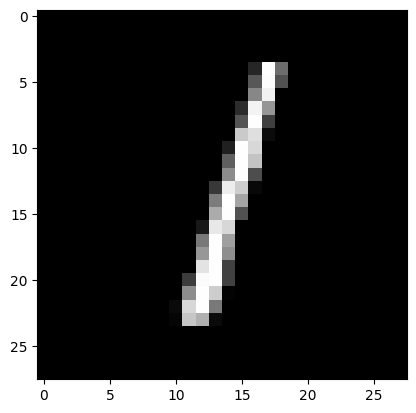

In [54]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[2]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim = 1, keepdim = True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap = 'gray')
plt.show